ROC analysis

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix as cm
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt 
import ast
from sklearn import metrics

In [4]:
def str2list(arr):
    int_array = np.zeros((arr.shape[0], 3))
    for i, row in enumerate(arr):
        row = row.replace('[', '').replace(']', '')
        int_array[i] = np.fromstring(row, sep=' ')
    return int_array

In [43]:
def somaticTest(model):
    if model == "ecole-ft-somatic":
        ecole_predictions_path = "./ecole-ft-somatic_predictions_somatic_test/"
    elif model == "ecole":
        ecole_predictions_path = "./ecole_predictions_somatic_test/"
    else:
        raise ValueError('You have typed a wrong name for model name!')

    cur_dirname = os.getcwd()

    samples = [sample.split(".")[0] for sample in os.listdir(ecole_predictions_path)]

    preds_ = np.array([])
    wgs_preds_ = np.array([])
    probs_ = np.empty((0,3))

    for sample_name in tqdm(samples):
        
        ecole_calls_data = pd.read_csv(ecole_predictions_path + sample_name + ".csv", sep=",",header=None)
        wgs_calls_data = pd.read_csv(os.path.join(cur_dirname,f"../../../Groundtruths_exon_matched/Somatic_exon_matched_truths/Groundtruth_") + sample_name + ".vcf.csv", sep=",",header=None)
        new_df = pd.merge(wgs_calls_data, ecole_calls_data,  how='left', left_on=[0,1,2], right_on = [0,1,2]).values
        wgs_preds_n = np.array(new_df[:,3]) 
        wgs_preds_ = np.append(wgs_preds_,wgs_preds_n)
        preds_n= np.array(new_df[:,4]) 
        preds_ = np.append(preds_,preds_n)
        probs_n = str2list(new_df[:,5])
        probs_ = np.append(probs_,probs_n,axis=0)
        
            
    wgs_preds_[wgs_preds_ == "<DEL>"] = 2
    wgs_preds_[wgs_preds_ == "<DUP>"] = 1
    wgs_preds_[wgs_preds_ == "<NO-CALL>"] = 0
    wgs_preds_ = wgs_preds_.astype(int)

    print("DEL AUC Score: "+str(metrics.roc_auc_score(wgs_preds_==2,probs_[:,2])))
    print("DUP AUC Score: "+str(metrics.roc_auc_score(wgs_preds_==1,probs_[:,1])))
    del_fpr, del_tpr, del_thresholds = metrics.roc_curve(wgs_preds_, probs_[:,2], pos_label=2)
    dup_fpr, dup_tpr, dup_thresholds = metrics.roc_curve(wgs_preds_, probs_[:,1], pos_label=1)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    ax1.plot(del_fpr,del_tpr)
    ax1.set_title("DEL ROC Curve"+' ('+model+')')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    ax2.plot(dup_fpr,dup_tpr)
    ax2.set_title("DUP ROC Curve"+' ('+model+')')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')
    plt.show()

100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


DEL AUC Score: 0.5652436602776617
DUP AUC Score: 0.48689137809067407


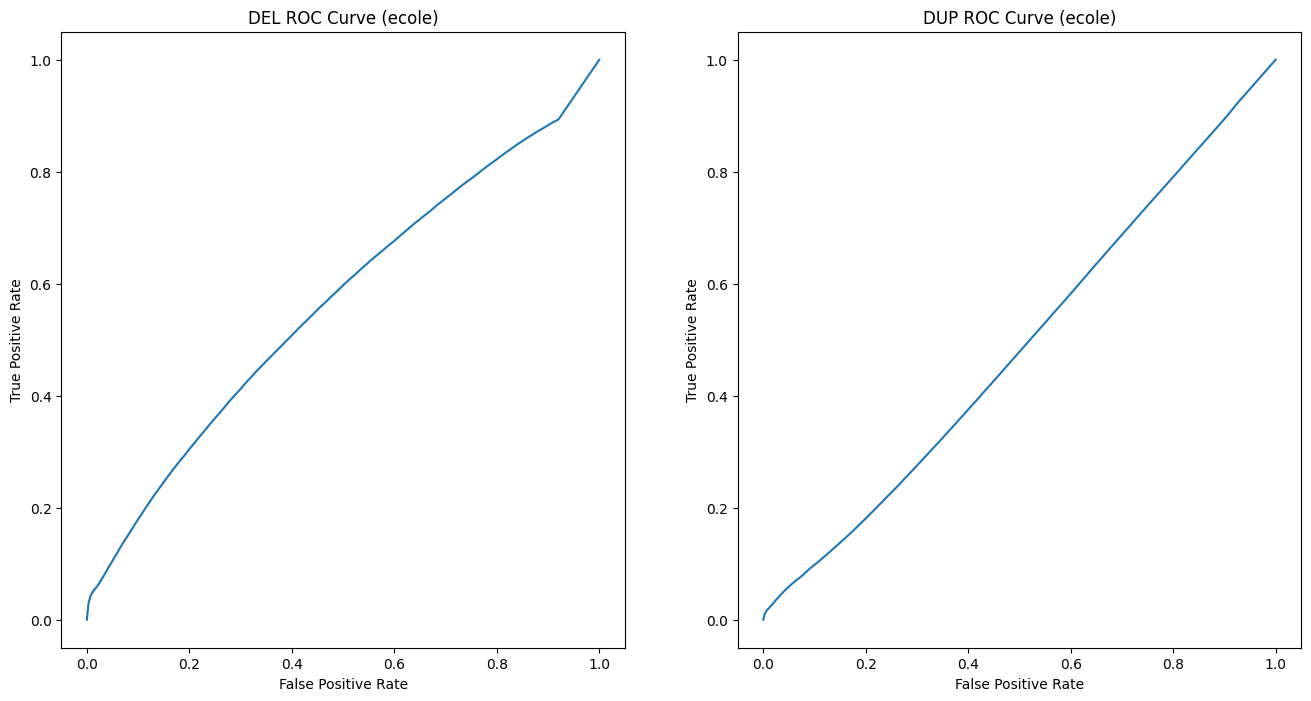

In [44]:
somaticTest("ecole")

100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


DEL AUC Score: 0.6602784611726753
DUP AUC Score: 0.5529812075708603


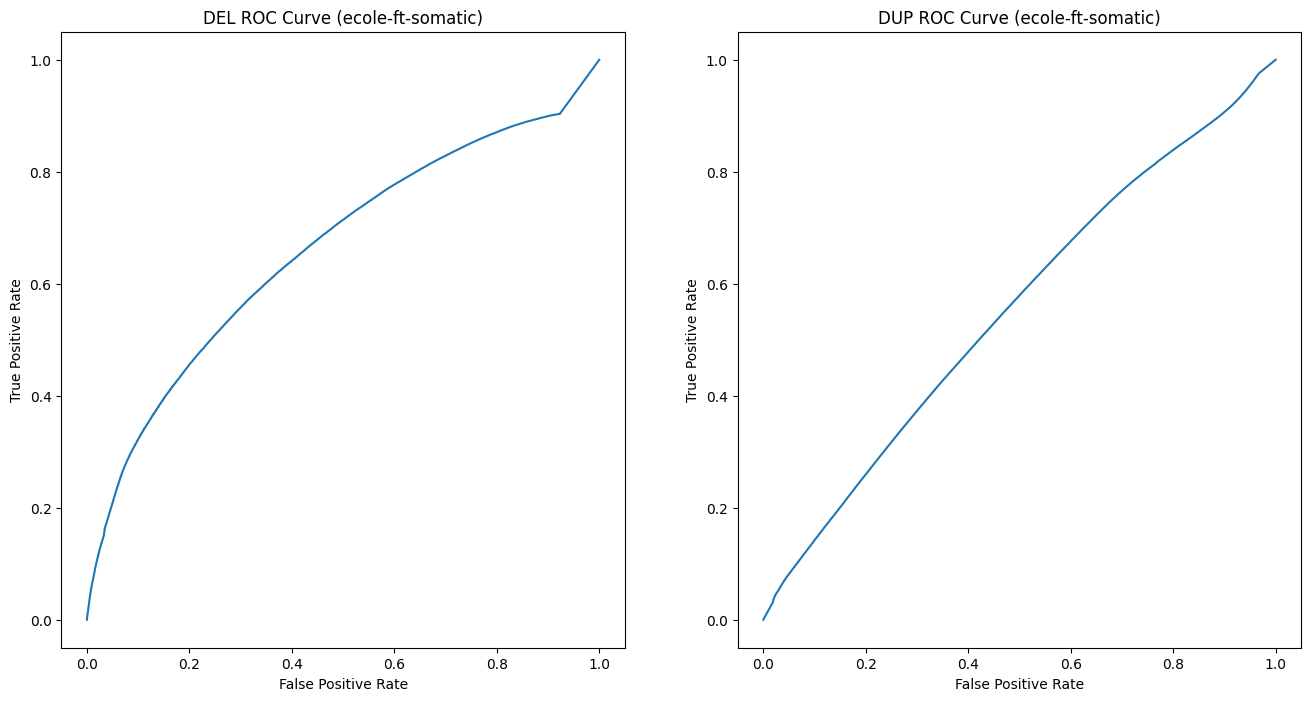

In [47]:
somaticTest("ecole-ft-somatic")